In [ ]:
import numpy as np
import pandas as pd 

In [ ]:
api_key = 'v4IdZHk57NCd10ibBf2aRfNoW'

api_secret_key = 'DzgXn6Ne7UgIRBRa8NhEm3EI5E02R1JfXK06AfTQuXkJOTHaDK'

access_key =  '1107526326049632256-OSbgMkGepOw7DykXrtraeY1urr5nhP'

access_secret = '7cUYUn5sC8U1pLbJ6athh5rlPy3opr7J4GLOSfZbJ1JjQ'

In [ ]:
import tweepy as tw
import pandas as pd

# Use credentials to authorize access
auth = tw.OAuthHandler(api_key, api_secret_key)
auth.set_access_token(access_key, access_secret)
api = tw.API(auth, wait_on_rate_limit=True)

In [ ]:
def search_positive(search_words, num_item):
  search_with_filter = search_words + " -filter:retweets"
  date_since = "2020-01-01"
  word = tw.Cursor(api.search,
                        q=search_with_filter,
                        lang="en",
                        since=date_since,
                        result_type = 'recent').items(num_item)
  a = [tweet.text for tweet in word]
  df = pd.DataFrame(a, columns = ['tweet'])
  df['attitude'] = 1
  return df

def search_negative(search_words, num_item):
  search_with_filter = search_words + " -filter:retweets"
  date_since = "2020-01-01"
  word = tw.Cursor(api.search,
                        q=search_with_filter,
                        lang="en",
                        since=date_since,
                        result_type = 'recent').items(num_item)
  a = [tweet.text for tweet in word]
  df = pd.DataFrame(a, columns = ['tweet'])
  df['attitude'] = -1
  return df

In [ ]:
maskdf1 = search_positive('#maskon', 350)
maskdf2 = search_positive('#wearmask', 400)

In [ ]:
maskdf3 = search_positive('#wearamask', 3000)

In [ ]:
n_maskdf1 = search_negative('#nomasks', 400)
n_maskdf2 = search_negative('#TakeOffYourMask', 3000)
n_maskdf3 = search_negative('#maskfree', 40)

In [ ]:
df = pd.concat([maskdf1, maskdf2, maskdf3, n_maskdf1, n_maskdf2, n_maskdf3], ignore_index=True)
df = df.drop_duplicates()
df

,tweet,attitude
0,Prevent CORONA from spreading. Always wear mas...,1
1,#SAFEkaDITOsaDDH\n\n#DidYouKnow that wearing a...,1
2,My office for the day 😎\n\n#CannaProShow\n#DJM...,1
3,🖤\nMask up to protect loved ones!\n#miranburha...,1
4,@Lophophanes @NatNewbiggin X20 Haymarket to Ly...,1
...,...,...
7185,"So according to this CDC study in 2020, masks ...",-1
7186,@Benz_girl7 @FOXLA Doubt it seriously #freecal...,-1
7187,@BeeBeekatz @MsJoeCool I walked into a gas sta...,-1
7188,"And, no mask required signs to be seen anywher...",-1


1) Tokenize

In [ ]:
def tokenize(df):
  token = []
  for tweet in df['tweet']:
    token.append(tweet.split())
  return token

In [ ]:
df['tokens'] = tokenize(df)

2) Remove URL

In [ ]:
import re

def no_links(df):
  tokens_no_links = []
  for tweet in df['tokens']:
    tokens_no_links.append([re.sub('^http.*$','', t) for t in tweet])
  return tokens_no_links

def no_at(df):
  tokens_no_at = []
  for tweet in df['tokens']:
    tokens_no_at.append([re.sub('^@.*$','', t) for t in tweet])
  return tokens_no_at


In [ ]:
df['tokens'] = no_links(df)
df['tokens'] = no_at(df)

3) Remove tags that we used for searching

In [ ]:
def remove_tag(df, tag):
  tokens = []
  for tweet in df['tokens']:
    tokens.append([re.sub(tag,'', t) for t in tweet])
  return tokens


In [ ]:
df['tokens'] = remove_tag(df, '^#[mM][aA][sS][kK][oO][nN].*$')
df['tokens'] = remove_tag(df, '^#[wW][eE][aA][rR][mM][aA][sS][kK].*$')
df['tokens'] = remove_tag(df, '^#[wW][eE][aA][rR][aA][mM][aA][sS][kK].*$')
df['tokens'] = remove_tag(df, '^#[nN][oO][mM][aA][sS][kK][sS].*$')
df['tokens'] = remove_tag(df, '^#[tT][aA][kK][eE][oO][fF][fF][yY][oO][uU][rR][mM][aA][sS][kK].*$')
df['tokens'] = remove_tag(df, '^#[mM][aA][sS][kK][fF][rR][eE][eE].*$')

4) Remove all punctuation

In [ ]:
def remove_punct(df):
  temp = []
  tokens_no_punct = []
  for row in df["tokens"]:
    temp.append([re.sub('[^\w\s]','', t) for t in row])
  for row in temp:
    tokens_no_punct.append([w for w in row if w != ''])
  return tokens_no_punct

# Covert all row into lowercase
def convert_lower(df):
  tokens_lowercase = []
  for row in df["tokens"]:
    tokens_lowercase.append([t.lower() for t in row])
  return tokens_lowercase



In [ ]:
df["tokens"] = remove_punct(df)
df["tokens"] = convert_lower(df)

5) Stemming

In [ ]:
from nltk.stem.porter import *

def stem(df):
  stemmer = PorterStemmer()
  stemed = []
  for tweet in df['tokens']:
    stemed.append([stemmer.stem(w) for w in tweet])
  return stemed


In [ ]:
df["tokens"] = stem(df)

6) Remove Stopwords

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

def remove_stopwords(df):
  sw = stopwords.words('english')[:1000]
  tokens_no_sw = []
  for row in df['tokens']:
    tokens_no_sw.append([w for w in row if w not in sw])
  return tokens_no_sw


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df['tokens'] = remove_stopwords(df)

6) lemmatization

In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

def lemmatize(df):
  lemmatizer = WordNetLemmatizer()
  lem_tokens = []
  for row in df['tokens']:
    lem_tokens.append([lemmatizer.lemmatize(t) for t in row])
  return lem_tokens


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df['tokens'] = lemmatize(df)

7) Count Vectorizing

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split

# Separate labels from features, converting to numpy arrays
X, y = df['tokens'].to_numpy(), df['attitude'].to_numpy()


def override_fcn(doc):
  # We expect a list of tokens as input
  return doc

# Count Vectorizer
count_vec = CountVectorizer(
    analyzer='word',
    tokenizer= override_fcn,
    preprocessor= override_fcn,
    token_pattern= None,
    max_features = 1000)

# Remember this output is a Scipy Sparse Array
counts = count_vec.fit_transform(X)
print(counts.toarray())

# Print the names of each of the features (1000 total))
print(count_vec.get_feature_names())
# Print this mapping as dictionary
print(count_vec.vocabulary_)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
['0711377544', '1', '10', '100', '12', '15', '17', '19', '1st', '2', '20', '2020', '2021', '21', '24', '2nd', '3', '30', '379', '3rd', '4', '5', '50', '6', '7', '8', 'abl', 'abov', 'absolut', 'abus', 'accept', 'accord', 'account', 'across', 'act', 'action', 'activ', 'actual', 'adult', 'advic', 'age', 'ago', 'agre', 'ahead', 'aint', 'air', 'alert', 'allah', 'allow', 'almost', 'alon', 'along', 'alreadi', 'also', 'alway', 'amaz', 'america', 'american', 'amp', 'ani', 'announc', 'anoth', 'antimask', 'anyon', 'anyth', 'anyway', 'apart', 'appoint', 'apr', 'april', 'aprilfoolsday', 'area', 'arent', 'arm', 'around', 'arrest', 'art', 'as', 'ask', 'asshol', 'asymptomat', 'avail', 'avoid', 'awar', 'away', 'awesom', 'b', 'babi', 'back', 'bad', 'ban', 'bar', 'base', 'basic', 'bastard', 'batman', 'bc', 'beach', 'beauti', 'becaus', 'becom', 'bed', 'bedroom', 'bedwett', 'befor', 'begi

In [ ]:
positive = []
negative = []

X, y = df['tokens'].to_numpy(), df['attitude'].to_numpy()

for i in range(len(X)):
  if y[i] == 1:
    positive.append(X[i])
  else:
    negative.append(X[i])

count_vec_postop = CountVectorizer(
    analyzer='word',
    tokenizer= override_fcn,
    preprocessor= override_fcn,
    token_pattern= None,
    max_features = 5500)

# Remember this output is a Scipy Sparse Array
count_vec_postop.fit_transform(positive)

# Print the names of each of the features (1000 total))
token_freq_p = count_vec_postop.vocabulary_

count_vec_negtop = CountVectorizer(
    analyzer='word',
    tokenizer= override_fcn,
    preprocessor= override_fcn,
    token_pattern= None,
    max_features = 5500)

# Remember this output is a Scipy Sparse Array
count_vec_negtop.fit_transform(negative)

# Print the names of each of the features (1000 total))
token_freq_n = count_vec_negtop.vocabulary_


sort_orders_p = sorted(token_freq_p.items(), key=lambda x: x[1], reverse=True)
sort_orders_n = sorted(token_freq_n.items(), key=lambda x: x[1], reverse=True)

p = sorted(token_freq_p, key=token_freq_p.get, reverse=True)
n = sorted(token_freq_n, key=token_freq_n.get, reverse=True)

p_result = []
n_result = []

for i in p[:20]:
  if i not in n[:20]:
    p_result.append(i)
for i in n[:20]:
  if i not in p[:20]:
    n_result.append(i)

print(p_result)
print(n_result)


print("Top 20 words for 1: ", p[:20])
print("Top 20 words for -1: ", n[:20])

['𝚝𝚛𝚢', '𝚝𝚘', '𝚝𝚑𝚊𝚝', '𝚝𝚊𝚔𝚎', '𝚜𝚞𝚗𝚗𝚢', '𝚜𝚑𝚘𝚞𝚕𝚍', '𝚘𝚏', '𝚖𝚘𝚖𝚎', '𝚒𝚝', '𝚒𝚜', '𝚎𝚟𝚎𝚛𝚢', '𝚎𝚗𝚓𝚘𝚢', '𝚍𝚊𝚢', '𝚌𝚊𝚛𝚎𝚏𝚞𝚕', '𝚌𝚊𝚛𝚎', '𝚋𝚎', '𝚊', '𝙿𝚕𝚎𝚊𝚜𝚎', '𝙷𝚘𝚠𝚎𝚟𝚎𝚛', '𝙱𝚎𝚜𝚒𝚍𝚎𝚜']
['𝗪𝗘𝗔𝗥', '𝗠𝗔𝗦𝗞', '𝗙𝗨𝗖𝗞𝗜𝗡𝗚', '𝗔', 'zon', 'zombi', 'zi', 'zero', 'z', 'yvonn', 'yup', 'yung', 'yucki', 'yr', 'ypur', 'yp', 'youv', 'youtub', 'youthat', 'youth']
Top 20 words for 1:  ['𝚝𝚛𝚢', '𝚝𝚘', '𝚝𝚑𝚊𝚝', '𝚝𝚊𝚔𝚎', '𝚜𝚞𝚗𝚗𝚢', '𝚜𝚑𝚘𝚞𝚕𝚍', '𝚘𝚏', '𝚖𝚘𝚖𝚎', '𝚒𝚝', '𝚒𝚜', '𝚎𝚟𝚎𝚛𝚢', '𝚎𝚗𝚓𝚘𝚢', '𝚍𝚊𝚢', '𝚌𝚊𝚛𝚎𝚏𝚞𝚕', '𝚌𝚊𝚛𝚎', '𝚋𝚎', '𝚊', '𝙿𝚕𝚎𝚊𝚜𝚎', '𝙷𝚘𝚠𝚎𝚟𝚎𝚛', '𝙱𝚎𝚜𝚒𝚍𝚎𝚜']
Top 20 words for -1:  ['𝗪𝗘𝗔𝗥', '𝗠𝗔𝗦𝗞', '𝗙𝗨𝗖𝗞𝗜𝗡𝗚', '𝗔', 'zon', 'zombi', 'zi', 'zero', 'z', 'yvonn', 'yup', 'yung', 'yucki', 'yr', 'ypur', 'yp', 'youv', 'youtub', 'youthat', 'youth']


8) TFIDF

In [ ]:
tfidf = TfidfTransformer()

tfs = tfidf.fit_transform(counts)

# Let's use the TFIDF counts for modelling
X = tfs.toarray()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

9) Naive Bayes Formula

Test accuracy with simple Naive Bayes: 0.7791754018169113


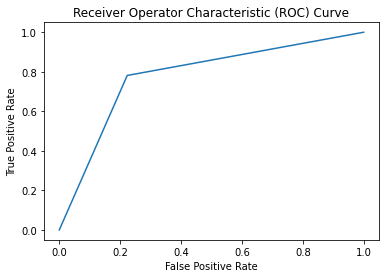

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_curve
import matplotlib.pyplot as plt

# Let's fit the Naive Bayes model to our training data
nb = MultinomialNB()
# Fit model to training data
nb.fit(X_train, y_train)
# Predict on test data
y_preds = nb.predict(X_test)

print('Test accuracy with simple Naive Bayes:',accuracy_score(y_test,y_preds))
# We get a very good accuracy, despite class imbalance (recall 87% were Ham)
# # Plot the ROC curve 
fpr, tpr, thresholds = roc_curve(y_test, y_preds, pos_label = 1)

plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operator Characteristic (ROC) Curve')
plt.show()

Country Plot

In [ ]:
def coordinate(search_words, num_items, country):
  search_with_filter = search_words + " -filter:retweets"
  date_since = "2020-01-01"
  searchCountry = country
  places = api.geo_search(query=searchCountry, granularity="country")
  place_id = places[0].id
  mask = tw.Cursor(api.search,
                  q='{} place:{}'.format(search_with_filter, place_id),
                  lang="en",
                  since=date_since,
                  result_type = 'recent').items(num_items)
  l_coordinates = []
  for tweet in mask:
    if tweet.coordinates is not None:
      l_coordinates1.append(tweet.coordinates['coordinates'])
  return l_coordinates

In [ ]:
def countrycode(search_words, num_items):
  search_with_filter = search_words + " -filter:retweets"
  date_since = "2020-01-01"
  mask = tw.Cursor(api.search,
                  q=search_with_filter,
                  lang="en",
                  since=date_since,
                  result_type = 'recent').items(num_items)
  l_countrycode = []
  for tweet in mask:
    if tweet.place is not None:
      l_countrycode.append(tweet.place.country_code)
  return l_countrycode

Masks


1. Positive


<BarContainer object of 30 artists>

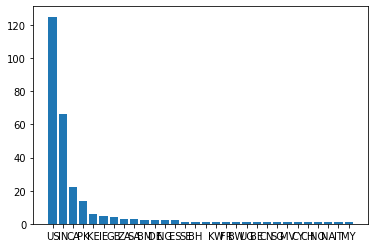

In [ ]:
import matplotlib.pyplot as plt
mask1 = countrycode(search_words='#maskon', num_items=1000)
mask2 = countrycode(search_words='#wearmask', num_items=1000)
mask3 = countrycode(search_words='#wearamask', num_items=4000)
mask =  mask1 + mask2 + mask3

maskdf = pd.DataFrame(mask, columns=['count'])
maskdf = maskdf['count'].value_counts().to_frame().reset_index()

2. Negative

<BarContainer object of 8 artists>

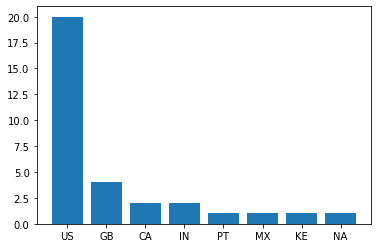

In [ ]:
import matplotlib.pyplot as plt

n_mask = countrycode(search_words='#maskfree', num_items=1000) + countrycode(search_words='#nomasks', num_items=1000) + countrycode(search_words='#takeoffyourmask', num_items=1000)

n_maskdf = pd.DataFrame(n_mask, columns=['count'])
n_maskdf = n_maskdf['count'].value_counts().to_frame().reset_index()

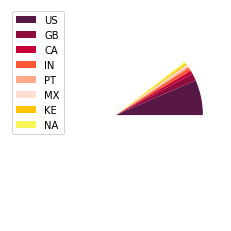

In [ ]:
sum = len(n_mask) + len(mask)
n_maskdf['proportion'] = n_maskdf['count']/sum
maskdf['proportion'] = maskdf['count']/len(n_mask)
color1 = ['#581845', '#900C3F', '#C70039', '#FF5733', '#FFA98B', '#FFDED3', '#FFC300', '#F7F659', '#FFFFA4', '#DAF7A6']
plt.pie(n_maskdf['proportion'], colors=color1)
plt.legend(n_maskdf['index'])
plt.show() 

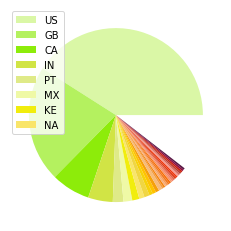

In [ ]:
sum = len(n_mask) + len(mask)
maskdf['proportion'] = maskdf['count']/sum
color2 = ['#DAF7A6','#B4F15F', '#8DEC0A', '#D1E445', '#DFEA88', '#EFF9A6', '#F1ED0D', '#F9E56A', '#F0D643', '#F6D20A', 
          '#FFC300', '#F6A00A', '#F7BB7A', '#F19E47', '#F6830A', '#F7AF7A', '#F79C59', '#F07820', '#F96C04', '#F59769',
          '#F58269', '#E16448', '#E03B16', '#F0350B', '#F69D93', '#D76E62', '#BC3E2F', '#CB1D09', '#900C3F', '#581845']
plt.pie(maskdf['proportion'], colors=color2)
plt.legend(n_maskdf['index'])
plt.show() 

Research 1: Prediction on someone's attitude about wearing a mask.

In [ ]:
def conclusion_maker(lst):
  if sum(lst) == 0:
    return "This media has neautral attitude"
  if sum(lst) < 0:
    return "This media has negative attitude"
  else:
    return "This media has positive attitude"

In [ ]:
def predict_attitude(new_df, training_df):
  new_df["tokens"] = tokenize(new_df)
  new_df["tokens"] = no_links(new_df)
  new_df["tokens"] = no_at(new_df)
  new_df["tokens"] = remove_punct(new_df)
  new_df["tokens"] = convert_lower(new_df)
  new_df["tokens"] = stem(new_df)
  new_df["tokens"] = remove_stopwords(new_df)
  new_df["tokens"] = lemmatize(new_df)

  new_X = new_df['tokens'].to_numpy()
  # Count Vectorizer
  count_vec_new = CountVectorizer(
      analyzer='word',
      tokenizer= override_fcn,
      preprocessor= override_fcn,
      token_pattern= None,
      max_features = 5500)

  X, y = training_df['tokens'].to_numpy(), training_df['attitude'].to_numpy()
  full_X_new = np.concatenate([X, new_X])

  counts_new = count_vec_new.fit_transform(full_X_new)

  tfidf_new = TfidfTransformer()

  tfs_new = tfidf_new.fit_transform(counts_new)

  new_X = tfs_new.toarray()

  X, X_test = new_X[:np.size(X), :], new_X[np.size(X):,:]

  nb_new = MultinomialNB()
  nb_new.fit(X, y)

  pred_new = nb_new.predict(X_test)
  return pred_new

In [ ]:
search_with_filter = "mask" +" from:@CDCgov"
date_since = "2020-01-01"
word = tw.Cursor(api.search,
                        q=search_with_filter,
                        lang="en",
                        since=date_since,
                        result_type = 'recent').items(1000)
a = [tweet.text for tweet in word]
df_CDC = pd.DataFrame(a, columns = ['tweet'])
df_CDC

,tweet
0,#WearAMask 😷 in public to help #SlowTheSpread ...
1,Help protect adult day service center particip...
2,"Wash your cloth mask daily, or more often if i..."
3,#WearAMask when you are taking care of someone...


In [ ]:
print(conclusion_maker(predict_attitude(df_CDC, df)))


This media has positive attitude


In [ ]:
search_with_filter = "mask" +" from:@ABC"
date_since = "2020-01-01"
word = tw.Cursor(api.search,
                        q=search_with_filter,
                        lang="en",
                        since=date_since,
                        result_type = 'recent').items(1000)
a = [tweet.text for tweet in word]
df_ABC = pd.DataFrame(a, columns = ['tweet'])
df_ABC


,tweet
0,Fully vaccinated individuals can resume low-ri...
1,Fully vaccinated individuals can resume low-ri...
2,BREAKING: Fully vaccinated individuals can res...
3,"RT @ABCNewsLive: ""We need to keep taking the m..."
4,Wisconsin Supreme Court strikes down Gov. Tony...


In [ ]:
print(conclusion_maker(predict_attitude(df_ABC, df)))

This media has positive attitude


In [ ]:
search_with_filter = "mask" +" from:@NBCNews"
date_since = "2020-01-01"
word = tw.Cursor(api.search,
                        q=search_with_filter,
                        lang="en",
                        since=date_since,
                        result_type = 'recent').items(1000)
a = [tweet.text for tweet in word]
df_NBC = pd.DataFrame(a, columns = ['tweet'])
df_NBC

,tweet
0,CDC Director Walensky warns of “impending doom...
1,Sarah Palin urges mask use after revealing Cov...
2,Sarah Palin urges mask use after revealing Cov...
3,Sarah Palin urges mask use after revealing Cov...
4,Sarah Palin urges mask use after revealing Cov...
5,Wisconsin Supreme Court strikes down governor'...
6,"RT @NBCNewsGraphics: Several states, including..."
7,"RT @NBCNewsNow: ""There's millions and millions..."
8,Michigan's hot spot for new cases has been the...
9,"NEW: CDC Director Walensky warns of ""impending..."


In [ ]:
print(conclusion_maker(predict_attitude(df_NBC, df)))

This media has negative attitude


In [ ]:
search_with_filter = "mask" +" from:@CNN"
date_since = "2020-01-01"
word = tw.Cursor(api.search,
                        q=search_with_filter,
                        lang="en",
                        since=date_since,
                        result_type = 'recent').items(1000)
a = [tweet.text for tweet in word]
df_CNN = pd.DataFrame(a, columns = ['tweet'])
df_CNN

,tweet
0,JUST IN: The CDC says that as long as coronavi...
1,Biden's infrastructure push kicked off in earn...
2,Alabama’s Gov. Kay Ivey will move ahead with h...


In [ ]:
print(conclusion_maker(predict_attitude(df_CNN, df)))

This media has negative attitude


Test Medias' attitudes on Vaccines

In [ ]:
search_with_filter = "vaccine" +" from:@ABC"
date_since = "2020-01-01"
word = tw.Cursor(api.search,
                        q=search_with_filter,
                        lang="en",
                        since=date_since,
                        result_type = 'recent').items(1000)
a = [tweet.text for tweet in word]
df_ABCv = pd.DataFrame(a, columns = ['tweet'])

In [ ]:
print(conclusion_maker(predict_attitude(df_ABCv, df3)))

This media has positive attitude


In [ ]:
search_with_filter = "vaccine" +" from:@NBCNews"
date_since = "2020-01-01"
word = tw.Cursor(api.search,
                        q=search_with_filter,
                        lang="en",
                        since=date_since,
                        result_type = 'recent').items(1000)
a = [tweet.text for tweet in word]
df_NBCv = pd.DataFrame(a, columns = ['tweet'])

In [ ]:
print(conclusion_maker(predict_attitude(df_NBCv, df3)))

This media has positive attitude


In [ ]:
search_with_filter = "vaccine" +" from:@CNN"
date_since = "2020-01-01"
word = tw.Cursor(api.search,
                        q=search_with_filter,
                        lang="en",
                        since=date_since,
                        result_type = 'recent').items(1000)
a = [tweet.text for tweet in word]
df_CNNv = pd.DataFrame(a, columns = ['tweet'])

In [ ]:
print(conclusion_maker(predict_attitude(df_CNNv, df3)))

This media has positive attitude


Research Question 2: Find tweets associated with masks, predict people's attitude using our model and to see how does the proportion of people who support masks change over time

In [ ]:
def create_sample(date1):
  search_words = '(covid.*mask|mask.*covid)|(covid.*mask.*covid)'
  search_with_filter = search_words + " -filter:retweets"
  date_since = date1
  mask = tw.Cursor(api.search,
                        q=search_with_filter,
                        lang="en",
                        since=date_since,
                        result_type = 'recent').items(2000)
  a = [tweet.text for tweet in mask]
  return pd.DataFrame(a, columns = ['tweet'])

In [ ]:
df2 = create_sample("2021-01-01")

In [ ]:
df2

,tweet
0,The fool who posed on a Australian flag mask. ...
1,Social Distance? Using of nose mask? Officials...
2,@Jasmijn53423438 @vickypallom @louslilshit @lw...
3,@blackkn05858615 No place in the world is norm...
4,@AndyBurnhamGM @KateWilton1 @Sacha_Lord @hugho...
...,...
1995,just because the covid vaccine is being releas...
1996,@laura_detroit @yesimblonde17 @TaylenandKatie ...
1997,@lululemon maybe I can show you pictures of my...
1998,@KVHendry @RosieDuffield1 @PCCKent It's weird ...


In [ ]:
df2["tokens"] = tokenize(df2)
df2["tokens"] = no_links(df2)
df2["tokens"] = no_at(df2)
df2["tokens"] = remove_punct(df2)
df2["tokens"] = convert_lower(df2)
df2["tokens"] = stem(df2)
df2["tokens"] = remove_stopwords(df2)
df2["tokens"] = lemmatize(df2)
df2

,tweet,tokens
0,The fool who posed on a Australian flag mask. ...,"[fool, pose, australian, flag, mask, clown, ru..."
1,Social Distance? Using of nose mask? Officials...,"[social, distanc, use, nose, mask, offici, col..."
2,@Jasmijn53423438 @vickypallom @louslilshit @lw...,"[loui, wa, photograph, mexico, without, mask, ..."
3,@blackkn05858615 No place in the world is norm...,"[place, world, normal, wear, mask, social, dis..."
4,@AndyBurnhamGM @KateWilton1 @Sacha_Lord @hugho...,"[rememb, time, peopl, allow, smoke, pub, woul]"
...,...,...
1995,just because the covid vaccine is being releas...,"[becaus, covid, vaccin, releas, dosnt, mean, g..."
1996,@laura_detroit @yesimblonde17 @TaylenandKatie ...,"[compli, wear, mask, social, distanc]"
1997,@lululemon maybe I can show you pictures of my...,"[mayb, show, pictur, face, look, like, wear, n..."
1998,@KVHendry @RosieDuffield1 @PCCKent It's weird ...,"[weird, becaus, texa, case, start, go, soon, s..."


In [ ]:
part2_X = df2['tokens'].to_numpy()

def override_fcn(doc):
  # We expect a list of tokens as input
  return doc

# Count Vectorizer
count_vec = CountVectorizer(
    analyzer='word',
    tokenizer= override_fcn,
    preprocessor= override_fcn,
    token_pattern= None,
    max_features = 5500)

X, y = df['tokens'].to_numpy(), df['attitude'].to_numpy()


# Remember this output is a Scipy Sparse Array
full_X = np.concatenate([X, part2_X])

part2_counts = count_vec.fit_transform(full_X)

tfidf = TfidfTransformer()

tfs = tfidf.fit_transform(part2_counts)

part2_X = tfs.toarray()

X, monthX = part2_X[:np.size(X), :], part2_X[np.size(X):,:]

nb = MultinomialNB()
nb.fit(X, y)

part2_pred = nb.predict(monthX)

In [ ]:
np.sum(part2_pred == 1)/2000

0.5675

Research Question 3 Vaccine

In [ ]:
vacdf1 = search_positive('#vaccinated', 1000)
vacdf2 = search_positive('#doyourpart', 300)
vacdf3 = search_positive('#vaccinate', 900)

In [ ]:
no_vacdf1 = search_negative('#novaccine', 150)
no_vacdf2 = search_negative('#novaccinepassport', 150)
no_vacdf3 = search_negative('#novaccineforme', 200)
no_vacdf4 = search_negative('#antivaxxers', 300)
no_vacdf5 = search_negative('#antivaccine', 100)
no_vacdf6 = search_negative('#antivaxxer', 100)
no_vacdf7 = search_negative('#antivax', 200)

In [ ]:
frame_vec = [vacdf1, vacdf2, vacdf3, no_vacdf1, no_vacdf2, no_vacdf3, no_vacdf4, no_vacdf5, no_vacdf6, no_vacdf7]
df3 = pd.concat(frame_vec)

In [ ]:
df3["tokens"] = tokenize(df3)
df3["tokens"] = no_links(df3)
df3["tokens"] = no_at(df3)
df3["tokens"] = remove_punct(df3)
df3["tokens"] = convert_lower(df3)
df3["tokens"] = stem(df3)
df3["tokens"] = remove_stopwords(df3)
df3["tokens"] = lemmatize(df3)

In [ ]:
df3['tokens'] = remove_tag(df3, '^#[vV][aA][cC][cC][iI][nN][aA][tT][eE][dD].*$')
df3['tokens'] = remove_tag(df3, '^#[dD][oO][yY][oO][uU][rR][pP][aA][rR][tT].*$')
df3['tokens'] = remove_tag(df3, '^#[vV][aA][cC][cC][iI][nN][aA][tT][eE].*$')
df3['tokens'] = remove_tag(df3, '^#[nN][oO][vV][aA][cC][cC][iI][nN][eE].*$')
df3['tokens'] = remove_tag(df3, '^#[nN][oO][vV][aA][cC][cC][iI][nN][eE][pP][aA][sS][sS][pP][oO][rR][tT].*$')
df3['tokens'] = remove_tag(df3, '^#[nN][oO][vV][aA][cC][cC][iI][nN][eE][fF][oO][rR][mM][eE].*$')
df3['tokens'] = remove_tag(df3, '^#[aA][nN][tT][iI][vV][aA][xX][xX][eE][rR][sS].*$')
df3['tokens'] = remove_tag(df3, '^#[aA][nN][tT][iI][vV][aA][cC][cC][iI][nN][eE].*$')
df3['tokens'] = remove_tag(df3, '^#[aA][nN][tT][iI][vV][aA][xX][xX][eE][rR].*$')
df3['tokens'] = remove_tag(df3, '^#[aA][nN][tT][iI][vV][aA][xX].*$')

In [ ]:
X3, y3 = df3['tokens'].to_numpy(), df3['attitude'].to_numpy()


def override_fcn(doc):
  # We expect a list of tokens as input
  return doc

# Count Vectorizer
count_vec3 = CountVectorizer(
    analyzer='word',
    tokenizer= override_fcn,
    preprocessor= override_fcn,
    token_pattern= None,
    max_features = 1000)

# Remember this output is a Scipy Sparse Array
counts3 = count_vec3.fit_transform(X3)

In [ ]:
tfidf3 = TfidfTransformer()

tfs3 = tfidf3.fit_transform(counts3)

print(tfs3.toarray())

# Let's use the TFIDF counts for modelling
X3 = tfs3.toarray()

# Split the data into training and test sets
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size = 0.2, random_state = 42)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Test accuracy with simple Naive Bayes: 0.8683431952662722


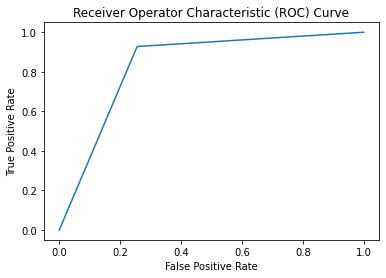

In [ ]:
nb3 = MultinomialNB()
# Fit model to training data
nb3.fit(X_train3, y_train3)
# Predict on test data
y_preds3 = nb3.predict(X_test3)

print('Test accuracy with simple Naive Bayes:',accuracy_score(y_test3,y_preds3))
# We get a very good accuracy, despite class imbalance (recall 87% were Ham)


# # Plot the ROC curve 
fpr, tpr, thresholds = roc_curve(y_test3, y_preds3, pos_label = 1)

plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operator Characteristic (ROC) Curve')
plt.show()

Use model for vaccine to predict for wearing mask, to see if we can get some interesting findings

In [ ]:
len(X_train3)

2704

In [ ]:
X_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Test accuracy with simple Naive Bayes: 0.7760355029585799


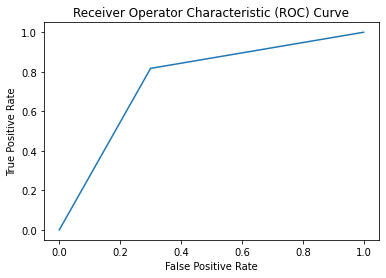

In [ ]:
X, y = df['tokens'].to_numpy(), df['attitude'].to_numpy()
X2, y2 = df3['tokens'].to_numpy(), df3['attitude'].to_numpy()

def override_fcn(doc):
  # We expect a list of tokens as input
  return doc

# Count Vectorizer
count_vec = CountVectorizer(
    analyzer='word',
    tokenizer= override_fcn,
    preprocessor= override_fcn,
    token_pattern= None,
    max_features = 1000)

# Remember this output is a Scipy Sparse Array
full_X = np.concatenate([X, X2])

counts = count_vec.fit_transform(full_X)

tfidf = TfidfTransformer()

tfs = tfidf.fit_transform(counts)

mv_X = tfs.toarray()

X, X2 = mv_X[:np.size(X), :], mv_X[np.size(X):,:]

nb = MultinomialNB()
nb.fit(X, y)

pred = nb.predict(X2)

print('Test accuracy with simple Naive Bayes:',accuracy_score(pred,y2))
# We get a very good accuracy, despite class imbalance (recall 87% were Ham)


# # Plot the ROC curve 
fpr, tpr, thresholds = roc_curve(y2,pred, pos_label = 1)

plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operator Characteristic (ROC) Curve')
plt.show()

In [ ]:
nb = MultinomialNB()
nb.fit(X2, y2)

pred = nb.predict(X)

print('Test accuracy with simple Naive Bayes:',accuracy_score(pred,y))
# We get a very good accuracy, despite class imbalance (recall 87% were Ham)


# # Plot the ROC curve 
fpr, tpr, thresholds = roc_curve(y,pred, pos_label = 1)

plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operator Characteristic (ROC) Curve')
plt.show()

NameError: ignored